Unter https://www.openml.org/d/41214 und https://www.openml.org/d/41215 finden Sie zwei Datensätze eines französischen Automobilversicherers. Diese beinhalten Risikomerkmale und Schadeninformationen zu Kraftfahrt-Haftpflicht-Versicherungsverträgen. Ihre Aufgabe besteht in der Modellierung der zu erwartenden Schadenhöhe pro Versicherungsnehmer und Jahr anhand der Risikomerkmale der Kunden. Dieser Wert ist Basis für die Berechnung eines fairen Versicherungsbeitrags.

Gehen Sie dabei in folgenden Teilschritten vor:

* Explorative Datenanalyse: Machen Sie sich mit dem Datensatz vertraut. Identifizieren Sie dabei mögliche Probleme sowie grundlegende statistische Zusammenhänge, welche für die anschließende Modellierung wichtig sein könnten.

* Feature Engineering: Bereiten Sie, soweit für ihre Modellierung nötig, die Variablen geeignet auf.

* Modellvergleich: Entscheiden Sie sich für ein geeignetes Modell anhand einer dafür geeigneten Metrik. Erläutern Sie wie Sie dabei vorgehen und begründen Sie ihre Entscheidung.

* Modellbuilding: Trainieren Sie unter Berücksichtigung der vorangegangenen Schritte das von Ihnen gewählte Modell zur Vorhersage der erwarteten Schadenhöhe pro Kunde und Jahr. Ihr Ziel ist es, einen möglichst fairen Versicherungsbeitrag pro Jahr für einzelne Kunden anhand der Ihnen zu Verfügung stehenden Merkmale zu bestimmen. Wählen Sie mindestens eine geeignete Metrik, um die Güte des finalen Modells zu beurteilen. Zeigen Sie, welche Variablen und Zusammenhänge für Ihr finales Modell relevant sind. Überlegen Sie sich (ohne dies umzusetzen) wie Sie Ihr Modell weiter optimieren könnten.


## Einlesen der Daten

* **Bemerkung:** Es ist nicht notwending, das `arff` Package zu benutzen. Das Einlesen der Daten läuft ganz normal mit `pd.read_csv`.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#@relation freMTPL2sev
#@attribute IDpol numeric
#@attribute ClaimAmount numeric
#@data

fname = "./data/freMTPL2sev.arff"
dfsev = pd.read_csv(fname, skiprows=4, header=None, names=["IDpol", "ClaimAmount"])
dfsev.head()

,IDpol,ClaimAmount
0,1552,995.20
1,1010996,1128.12
2,4024277,1851.11
3,4007252,1204.00
4,4046424,1204.00


In [3]:
colnames = ["IDpol"   , "ClaimNb", "Exposure", "Area",
            "VehPower", "VehAge" , "DrivAge" , "BonusMalus", 
            "VehBrand", "VehGas" , "Density" , "Region"]



fname = './data/freMTPL2freq.arff'
dffreq = pd.read_csv(fname, skiprows=14, header=None, names = colnames, quotechar="'")
dffreq["IDpol"] = dffreq["IDpol"].astype(np.int64)
dffreq.head()

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1,1,0.10,D,5,0,55,50,B12,Regular,1217,R82
1,3,1,0.77,D,5,0,55,50,B12,Regular,1217,R82
2,5,1,0.75,B,6,2,52,50,B12,Diesel,54,R22
3,10,1,0.09,B,7,0,46,50,B12,Diesel,76,R72
4,11,1,0.84,B,7,0,46,50,B12,Diesel,76,R72


# Elementare Datenanalyse

In [4]:
print("No. rows in dfsev             :  {} ".format(dfsev.shape[0]))
print("No. of unique IDpols in dfsev :  {} ".format(dfsev["IDpol"].unique().shape[0]))
print("No. columns in dfsev          :  {} ".format(dfsev.shape[1]))
print("No. rows in dffreq            :  {} ".format(dffreq.shape[0]))
print("No. of unique IDpols in dffreq:  {} ".format(dffreq["IDpol"].unique().shape[0]))
print("No. columns in dffreq         :  {} ".format(dffreq.shape[1]))

No. rows in dfsev             :  26639 
No. of unique IDpols in dfsev :  24950 
No. columns in dfsev          :  2 
No. rows in dffreq            :  678013 
No. of unique IDpols in dffreq:  678013 
No. columns in dffreq         :  12 


### Bemerkungen:

* Die Anzahl der einzigartigen IDpols in `dffreq` entspricht der Anzahl der Zeilen; jede kommt nur einmal vor und ist eindeutig.

* Das ist bei `dfsev` nicht der Fall. Dies liegt daran, dass ein bestimmtes `IDpol` mehrere Schadensmeldungen einreichen kann.

* Die Anzahl der Schadensmeldungen für ein bestimmtes `IDpol` in `dffreq` sollte idealerweise der Anzahl der Vorkommen dieses `IDpol` in `dfsev` entsprechen. (Andernfalls sollte der entsprechende Eintrag für `ClaimNb` in `dffreq` korrigiert werden.)

* `dffreq` enthält deutlich mehr `IDpols` als `dfsev`, da Letzteres nur diejenigen umfasst, die mindestens eine Schadensmeldung gemacht haben.

* Idealerweise sollten alle `IDpols` in `dfsev` auch in `dffreq` vorhanden sein. Diejenigen `IDpols`, die in `dfsev` vorhanden sind, aber nicht in `dffreq`, sollten aus `dfsev` entfernt werden.

In [5]:
# Überprüfung der Datentypen:
print(dffreq.dtypes)

IDpol           int64
ClaimNb         int64
Exposure      float64
Area           object
VehPower        int64
VehAge          int64
DrivAge         int64
BonusMalus      int64
VehBrand       object
VehGas         object
Density         int64
Region         object
dtype: object


In [6]:
# Überprüfung auf fehlende Werte:
print(dffreq.isna().sum())

IDpol         0
ClaimNb       0
Exposure      0
Area          0
VehPower      0
VehAge        0
DrivAge       0
BonusMalus    0
VehBrand      0
VehGas        0
Density       0
Region        0
dtype: int64


In [7]:
dffreq.describe()

,IDpol,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density
count,6.780130e+05,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000
mean,2.621857e+06,0.053247,0.528750,6.454631,7.044265,45.499122,59.761502,1792.422405
std,1.641783e+06,0.240117,0.364442,2.050906,5.666232,14.137444,15.636658,3958.646564
min,1.000000e+00,0.000000,0.002732,4.000000,0.000000,18.000000,50.000000,1.000000
25%,1.157951e+06,0.000000,0.180000,5.000000,2.000000,34.000000,50.000000,92.000000
50%,2.272152e+06,0.000000,0.490000,6.000000,6.000000,44.000000,50.000000,393.000000
75%,4.046274e+06,0.000000,0.990000,7.000000,11.000000,55.000000,64.000000,1658.000000
max,6.114330e+06,16.000000,2.010000,15.000000,100.000000,100.000000,230.000000,27000.000000


In [8]:
dfsev.isna().sum()

IDpol          0
ClaimAmount    0
dtype: int64

In [9]:
dfsev.describe()

,IDpol,ClaimAmount
count,2.663900e+04,2.663900e+04
mean,2.279864e+06,2.278536e+03
std,1.577202e+06,2.929748e+04
min,1.390000e+02,1.000000e+00
25%,1.087642e+06,6.868100e+02
50%,2.137413e+06,1.172000e+03
75%,3.180162e+06,1.228080e+03
max,6.113971e+06,4.075401e+06


### Entfernung der IDpols, die nicht in `dffreq` vorhanden sind

Diese sollten entfernt werden, da ihre Attribute nicht verfügbar sind.

In [10]:
IDpols_in_freq = list(dffreq["IDpol"].unique())
in_sev_but_not_in_freq = ~dfsev["IDpol"].isin( IDpols_in_freq )
print("IDpols in dfsev but not_in dffreq: ")
print(" ")
print(" IDpol    Count")
print(dfsev[in_sev_but_not_in_freq]["IDpol"].value_counts())

IDpols in dfsev but not_in dffreq: 
 
 IDpol    Count
2262511    66
2282134    36
2227533    25
2220367    24
2277846    23
2286775    21
Name: IDpol, dtype: int64


In [11]:
remove_IDpols = dfsev[in_sev_but_not_in_freq]["IDpol"].unique().tolist()
mask_remove = ~dfsev["IDpol"].isin(remove_IDpols)
dfsev = dfsev[mask_remove]
dfsev.reset_index(drop=True, inplace=True)

print("IDpols removed from dfsev:")
print(remove_IDpols)
print("Number of rows in dfsev after removing IDpols :   {}".format(dfsev.shape[0]))
print("Number of unique IDpols in dfsev after removing: {}".format(dfsev["IDpol"].unique().shape[0]))

IDpols removed from dfsev:
[2262511, 2277846, 2282134, 2286775, 2220367, 2227533]
Number of rows in dfsev after removing IDpols :   26444
Number of unique IDpols in dfsev after removing: 24944


### Überprüfung der Konsistenz der Anzahl der Schadensmeldungen

Die Anzahl der Schadensmeldungen für ein bestimmtes `IDpol` in `dffreq` sollte idealerweise der Anzahl der Vorkommen dieses `IDpol` in `dfsev` entsprechen. Ob das wirklich so ist, wird hier überprüft.

In [12]:
dfsev_IDcount = dfsev["IDpol"].value_counts()
dfsev_IDcount = pd.DataFrame(dfsev_IDcount).rename(columns={"IDpol":"count"})
dfsev_IDcount["IDpol"] = dfsev_IDcount.index
dfsev_IDcount.reset_index(drop=True, inplace=True)
dfsev_IDcount[["IDpol", "count"]]

,IDpol,count
0,2241683,16
1,3253234,11
2,3254353,11
3,2248174,9
4,2239279,8
...,...,...
24939,1121141,1
24940,1175739,1
24941,1022625,1
24942,1127849,1


In [13]:
dfmerge = pd.merge(dfsev_IDcount, dffreq[["IDpol","ClaimNb"]], on="IDpol", how="inner")

In [14]:
# dfmerge["count"] und dfmerge["ClaimNb"] sollten gleich sein.
(dfmerge["count"] - dfmerge["ClaimNb"]).value_counts()

 0    24943
-1        1
dtype: int64

In [15]:
# Ein IDpol stimmt nicht:
dfmerge[dfmerge["count"]!=dfmerge["ClaimNb"]]

,count,IDpol,ClaimNb
11484,1,4158255,2


In [16]:
# Das heißt, ClaimNb für IDpol 4158255 ist eigentlich 1 und nicht 2:
dffreq.loc[dffreq["IDpol"]==4158255, "ClaimNb"] = 1

# Explorative Datenanalyse

In [17]:
cat_vars = ["Area", "VehPower", "VehBrand", "VehGas", "Region"]
num_vars = ["ClaimNb", "Exposure", "VehAge", "DrivAge", "BonusMalus", "Density"]

### Numerische Variablen

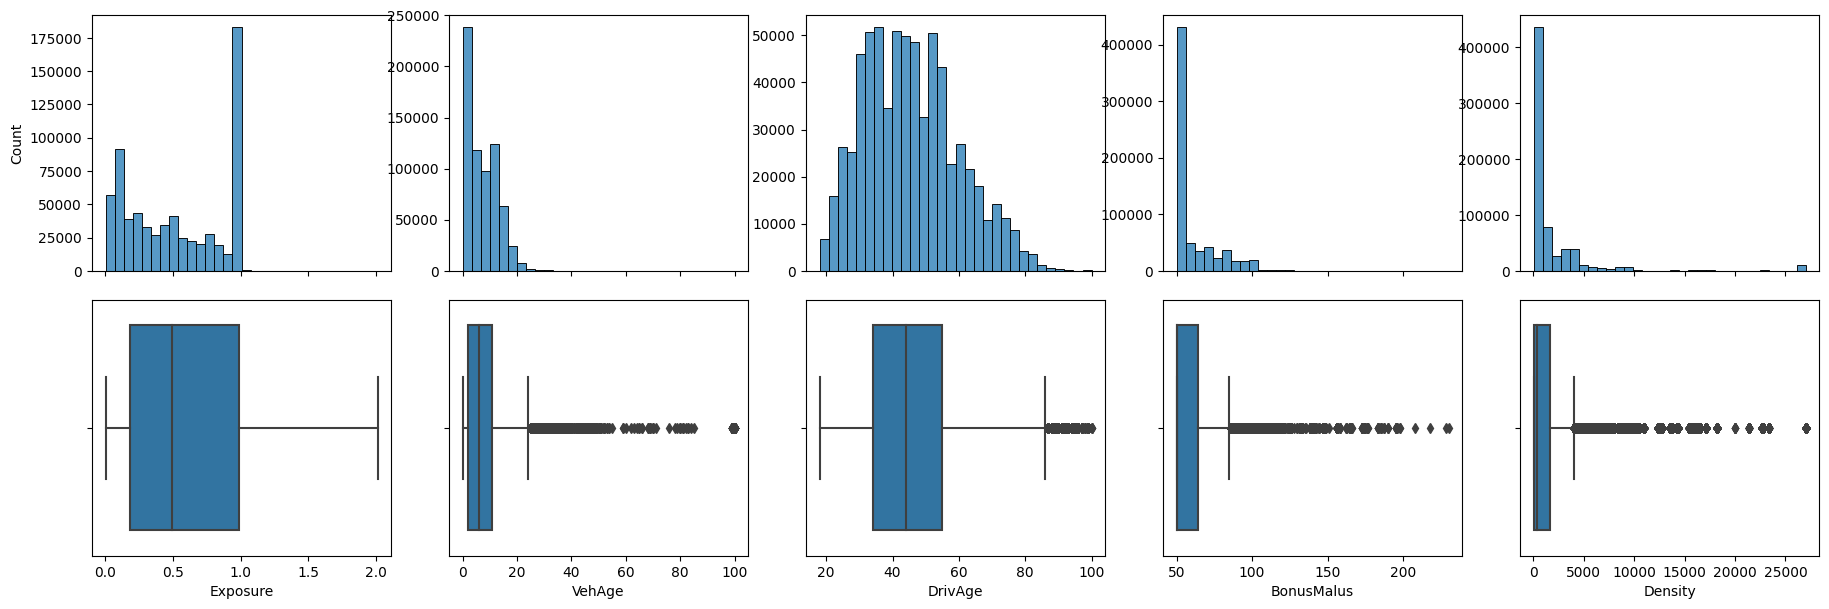

In [18]:
fig,ax=plt.subplots(2,5,figsize=(18,6), sharex="col")
plt.tight_layout()
for i,num_var in enumerate(num_vars[1:]):
    sns.histplot(x=num_var, data=dffreq, ax=ax[0,i], bins=30)
    sns.boxplot(x=num_var, data=dffreq, ax=ax[1,i])
for i in [1,2,3,4]:
    ax[0,i].set_ylabel("")

**Bemerkung:**

* Soll `Exposure` auf 1 begrenzt werden? Die Daten sind ja nur für ein Jahr...

### Kategorische Variablen

In [19]:
cat_vars

['Area', 'VehPower', 'VehBrand', 'VehGas', 'Region']

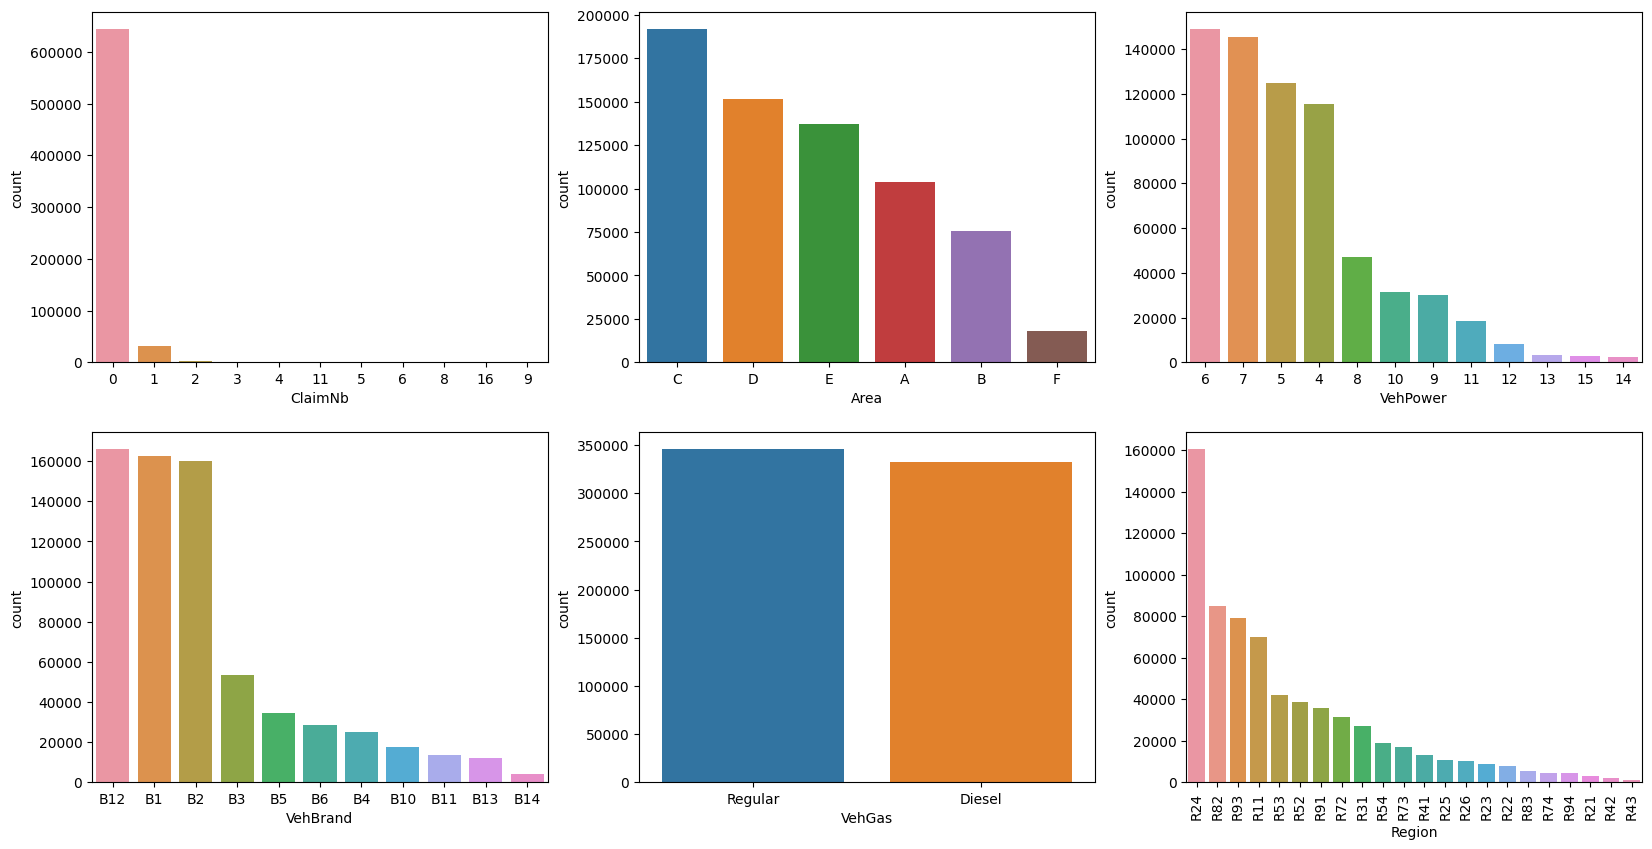

In [20]:
fig,ax=plt.subplots(2,3,figsize=(20,10))
for i,cat_var in enumerate(["ClaimNb"]+cat_vars):
    sns.countplot(x=cat_var, 
                  data=dffreq, 
                  order=dffreq[cat_var].value_counts().index,
                  ax=ax[int(i/3)][i%3])
ax[1,2].set_xticklabels(ax[1,2].get_xticklabels(), rotation=90);

**Bemerkungen:**

* `ClaimNb` ist streng genommen keine kategoriale Variable, wird hier jedoch der Einfachheit halber als solche dargestellt, da die Werte diskret sind.

* Gibt es einen Zusammenhang zwischen `Area` und `Region`?

* Für eine bessere Visualisierung können `BonusMalus`, `VehAge`, `Density` und `ClaimNb` auf einer logarithmischen Skala dargestellt werden.

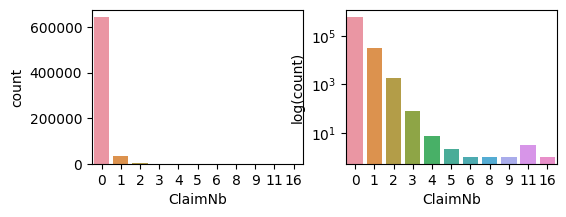

In [21]:
fig,ax=plt.subplots(1,2, figsize=(6,2))
sns.countplot(x="ClaimNb", data=dffreq, ax=ax[0])
ax[1].set_yscale('log')
sns.countplot(x="ClaimNb", data=dffreq, ax=ax[1])
ax[1].set_ylabel("log(count)");

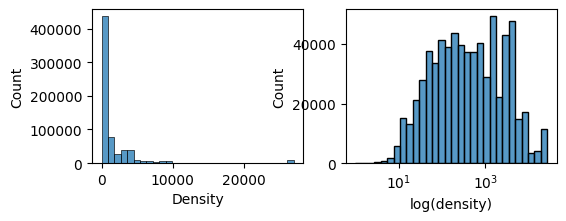

In [22]:
fig,ax=plt.subplots(1,2, figsize=(6,2))
ax[1].set_xscale('log')
sns.histplot(x=num_var, data=dffreq, ax=ax[0], bins=30)
sns.histplot(x=num_var, data=dffreq, ax=ax[1], bins=30)
ax[1].set_xlabel('log(density)');

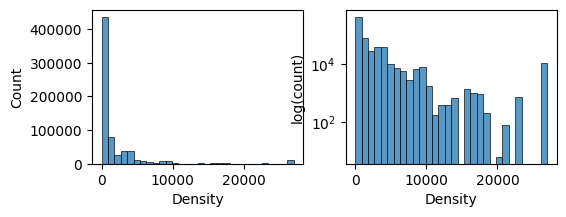

In [23]:
fig,ax=plt.subplots(1,2, figsize=(6,2))
ax[1].set_yscale('log')
sns.histplot(x=num_var, data=dffreq, ax=ax[0], bins=30)
sns.histplot(x=num_var, data=dffreq, ax=ax[1], bins=30)
ax[1].set_ylabel('log(count)');

## Korrelation zwischen Variablen

* Dies wird helfen, redundante Variablen zu identifizieren. 

* Sowohl der absolute Wert der Korrelationen als auch die Korrelationen selbst werden geplottet. 

* Ersteres wird helfen zu sehen, ob überhaupt eine Korrelation besteht (sei es positiv oder negativ), und letzteres wird helfen, das Vorzeichen zu erkennen.

In [24]:
dfcorr = dffreq[num_vars].corr()
dfcorr

,ClaimNb,Exposure,VehAge,DrivAge,BonusMalus,Density
ClaimNb,1.000000,0.068907,-0.021762,0.011403,0.050532,0.010755
Exposure,0.068907,1.000000,0.151554,0.171873,-0.183018,-0.071085
VehAge,-0.021762,0.151554,1.000000,-0.059213,0.079923,-0.090428
DrivAge,0.011403,0.171873,-0.059213,1.000000,-0.479966,-0.004700
BonusMalus,0.050532,-0.183018,0.079923,-0.479966,1.000000,0.077717
Density,0.010755,-0.071085,-0.090428,-0.004700,0.077717,1.000000


* Negative Korrelation zwischen `DrivAge` und `BonusMalus`.
* Positive Korrelation zwischen `Exposure` und `VehAge`.
* Positive Korrelation zwischen `Exposure` und `DrivAge`.
* Negative Korrelation zwischen `Exposure` und `BonusMalus`.
* Aber es werden keine wirklich starken Korrelationen beobachtet.

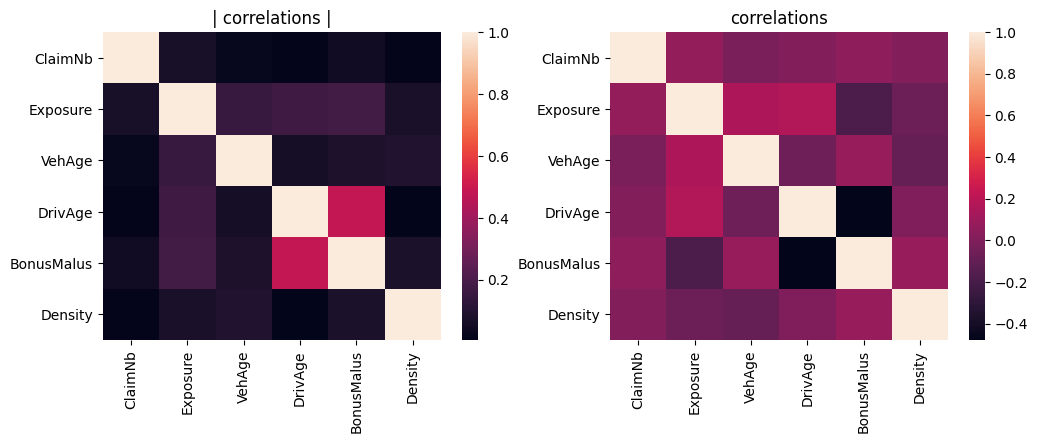

In [25]:
fig,ax=plt.subplots(1,2, figsize=(12,4))
sns.heatmap(dfcorr.abs(),ax=ax[0])
sns.heatmap(dfcorr,ax=ax[1])
ax[0].set_title("| correlations |")
ax[1].set_title("correlations");

# Einrichten der Zielvariable

* Hier wird die Zielvariable $y$ für jedes `IDpol` definiert.
* Die gesamten Schadensforderungen für jede `IDpol` werden summiert und durch die Exposition dieser `IDpol` dividiert. Dadurch ergibt sich die Zielvariable $y$ für jede `IDpol`.

In [26]:
dfsev_sum = dfsev.groupby("IDpol").sum()
dfsev_sum = dfsev_sum.reset_index()

In [27]:
df_data = pd.merge(dfsev_sum, dffreq, on="IDpol", how="outer")
df_data.reset_index(drop=True, inplace=True)
df_data["ClaimAmount"] = df_data["ClaimAmount"].fillna(0)
df_data["y"] = df_data["ClaimAmount"]/df_data["Exposure"]

### Entfernung inkonsistenter `IDpol`s

* Einige ID-Pols haben einen `ClaimNb` größer als 0, aber der `ClaimAmount` ist 0. Entweder enthält `dffreq` einen falschen Eintrag für `ClaimNb` oder diese Ansprüche fehlen in `dfsev`.

In [28]:
# IDpols with ClaimNb > 0 and ClaimAmount = 0
zero_amount_nonzero_claims = (df_data["ClaimAmount"]==0)&(df_data["ClaimNb"]>0)
ids_zero_amount_nonzero_claims = df_data.loc[zero_amount_nonzero_claims, "IDpol"].unique().tolist()
print("Number of IDs removed: {}".format(len(ids_zero_amount_nonzero_claims)))

# remove them:
keep_ids = ~df_data["IDpol"].isin(ids_zero_amount_nonzero_claims)
df_data = df_data.loc[keep_ids]
df_data.reset_index(drop=True, inplace=True)

Number of IDs removed: 9116


In [29]:
print("Shape of remaining dataframe: {}".format(df_data.shape))

Shape of remaining dataframe: (668897, 14)


In [30]:
print("Number of row with ClaimAmount > 0 and ClaimNb = 0: {}".format(
    df_data.loc[(df_data["ClaimAmount"]>0)&(df_data["ClaimNb"]==0)].shape[0]))

Number of row with ClaimAmount > 0 and ClaimNb = 0: 0


In [31]:
savefile = False
if savefile:
    df_data.to_csv("./data/df_data.csv", index=False)

### Bemerkungen zur unausgewogenen Natur des Datensatzes

In [32]:
claims_dist = (df_data["y"]>0.0).value_counts().tolist()
print("Number of cases with zero claims    : {}".format(claims_dist[0]))
print("Number of cases with non-zero claims:  {}".format(claims_dist[1]))
claims_dist = (df_data["y"]>0.0).value_counts(normalize=True).tolist()
print("Percentage of cases with zero claims    : {} %".format(round(100*claims_dist[0],2)))
print("Percentage of cases with non-zero claims:  {} %".format(round(100*claims_dist[1],2)))

Number of cases with zero claims    : 643953
Number of cases with non-zero claims:  24944
Percentage of cases with zero claims    : 96.27 %
Percentage of cases with non-zero claims:  3.73 %


* Nur etwa 4% der Daten enthalten Schadenmeldungen.
* Der Datensatz ist offensichtlich unausgewogen.
* Entweder konzentrieren wir uns nur auf den Fall y > 0.
* Oder wir stratifizieren die Train-Test- und K-Fold-Splits (Nachteil: Der Algorithmus wird Schadenmeldungen unterschätzen).
* Oder wir versuchen, den Datensatz auszugleichen. Methoden zum Ausgleichen des Datensatzes:
 - Undersampling (Entfernen der Mehrheitsklasse, um ihr Gewicht zu verringern)
 - Oversampling (Wiederholen der Minderheitsklasse, um ihr Gewicht zu erhöhen)
 - SMOTE (Erstellen ähnlicher Beispiele der Minderheitsklasse mittels statistischer Methoden)



In [33]:
df_data.loc[df_data["y"]>0, "y"].describe()

count    2.494400e+04
mean     1.041757e+04
std      1.916989e+05
min      1.000000e+00
25%      1.128000e+03
50%      1.504160e+03
75%      3.352010e+03
max      1.852455e+07
Name: y, dtype: float64

**Weitere Bemerkungen**

* Ein weiterer wichtiger Punkt ist, dass 75% der Fälle mit Schadenm€ eldungen unter dem $10^{3}$ € Bereich liegen.
* Die oberen Werte liegen jedoch im $10^{6}$-$10^{7}$ € Bereich. Ist das realistisch? Weist es auf einen Fehler bei der Dateneingabe hin?
* Sollte für $y$ eine Obergrenze angewendet werden?

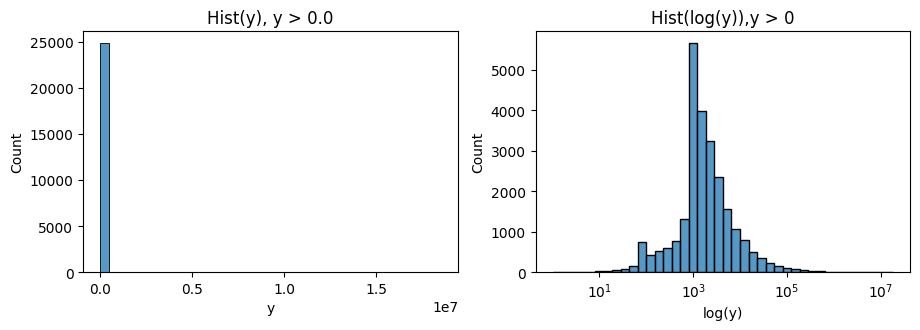

In [34]:
fig,ax=plt.subplots(1,2,figsize=(9,3))
plt.tight_layout(w_pad=2.5)
margin = 0.0
bins = 40
ax[1].set_xscale('log')
sns.histplot(df_data["y"].loc[df_data["y"]>0], ax=ax[0], bins=bins)
sns.histplot(df_data["y"].loc[df_data["y"]>0], ax=ax[1], bins=bins)
ax[0].set_title("Hist(y), y > {}".format(margin))
ax[1].set_title("Hist(log(y)),y > 0")
ax[1].set_xlabel("log(y)");

## Korrelation zwischen der Zielvariablen und anderen Variablen

* Die Korrelation zwischen der Zielvariable und anderen Variablen wird visualisiert.
* Für kategoriale Variablen wird $y$ für jede Kategorie aufsummiert, und die Summe wird durch die Anzahl der `IDpols` in jeder Kategorie dividiert. Dies ergibt die durchschnittliche Schadensforderung pro IDpol pro Kategorie.
* Die numerischen Variablen werden diskretisiert und als kategoriale Variablen dargestellt.

In [270]:
def get_normed_y(xvar, bins=None, binned=False):
    df_copy= df_data.copy()
    if binned:
        df_copy[xvar + "_bin"] = pd.cut(df_copy[xvar], bins=bins)
        xvar = xvar + "_bin"

    df1 = df_copy.groupby(xvar)[["y"]].sum()
    df1.reset_index(inplace=True)

    df2 = df_copy.groupby(xvar)[[xvar]].count()
    df2 = df2.rename(columns={xvar:"count"})
    df2.reset_index(inplace=True)

    df3 = pd.merge(df1,df2,on=xvar,how="outer")
    df3.reset_index(drop=True, inplace=True)

    df3["y_normed"] = df3["y"]/df3["count"]
    return df3

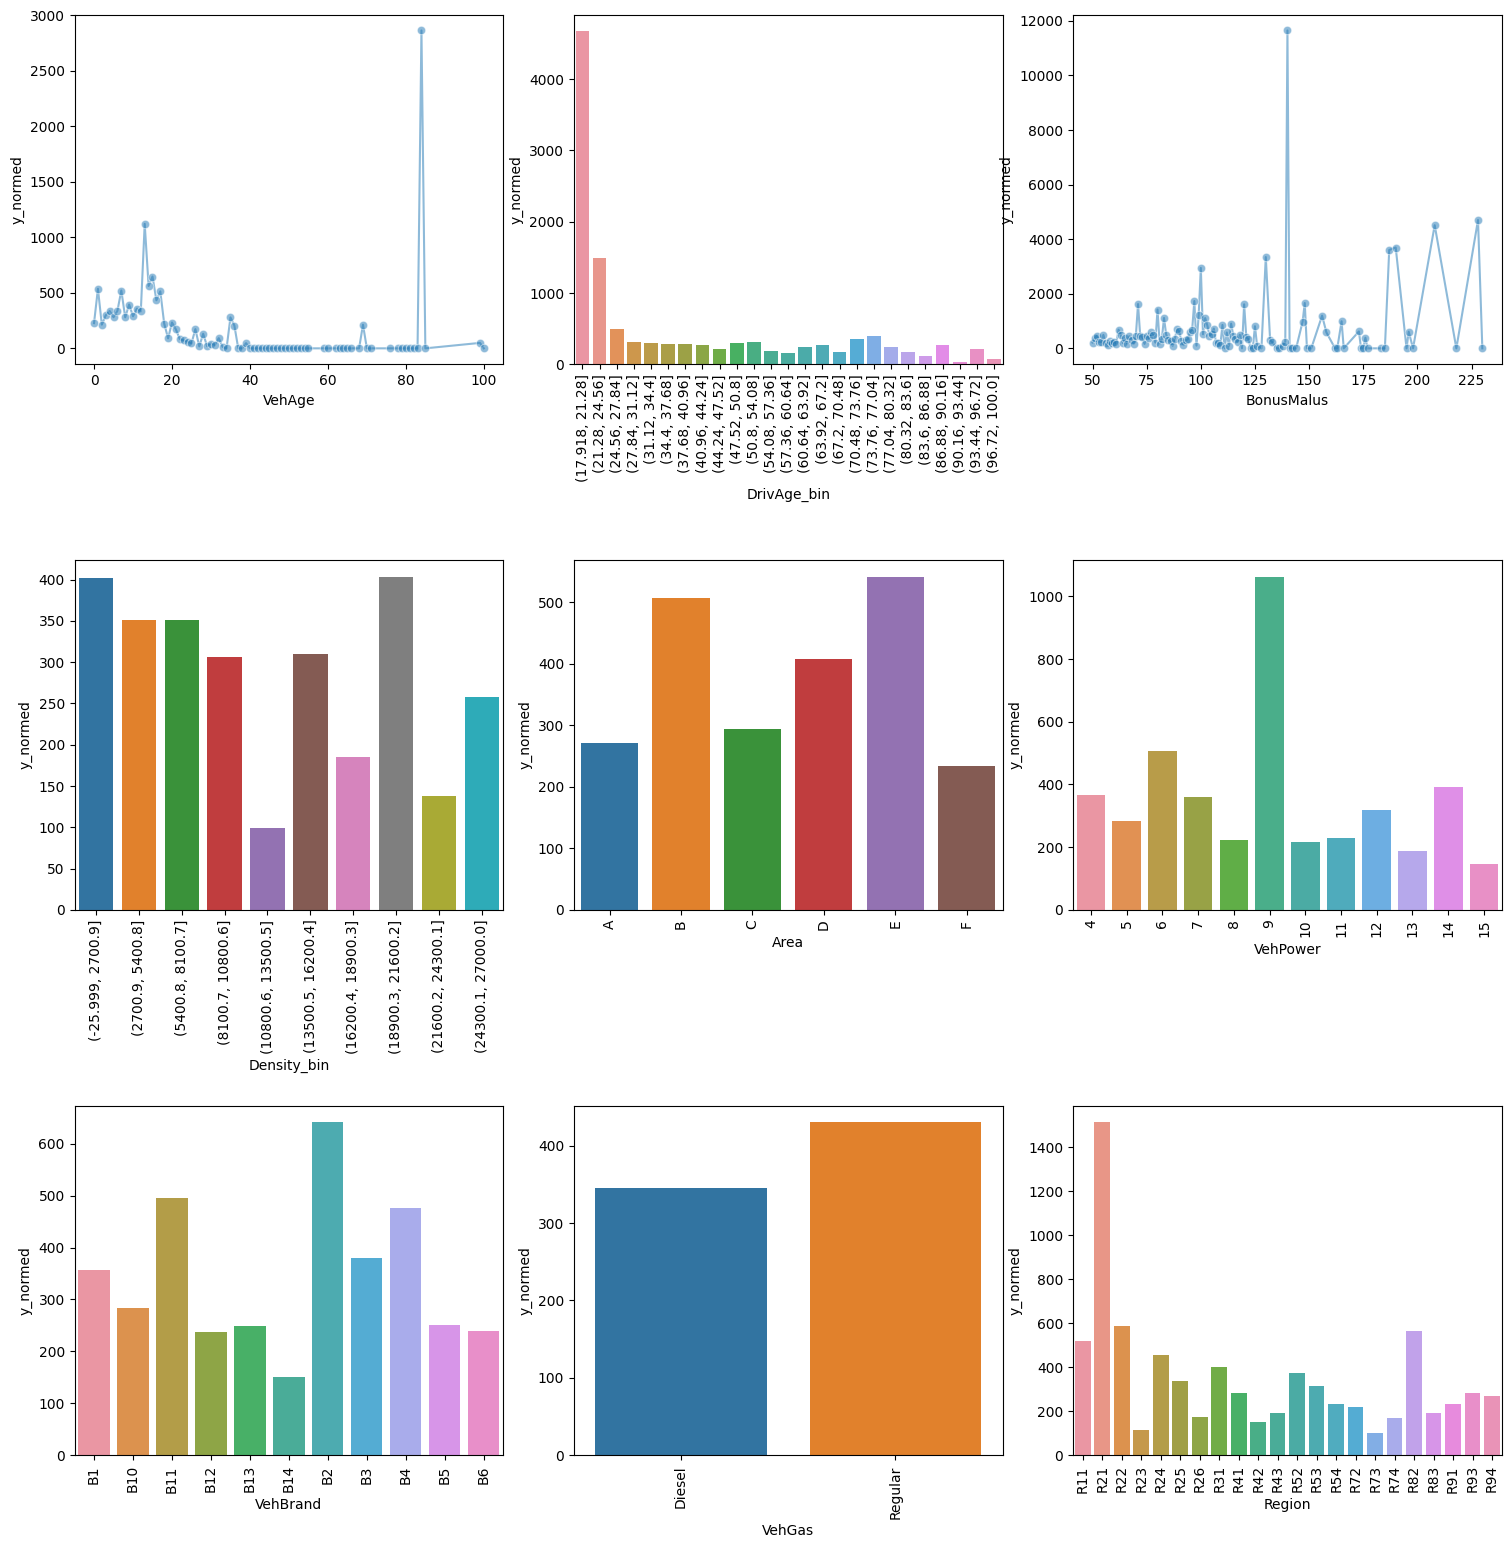

In [287]:
fig,ax = plt.subplots(3,3,figsize=(15,15))
plt.tight_layout(w_pad=2, h_pad=12)
dflist = []
xvarlist = ['VehAge', 'DrivAge', 'BonusMalus', 'Density','Area', 'VehPower', 'VehBrand', 'VehGas', 'Region']
binlist_bool = [False,True,False,True,False,False,False,False,False]
binval = [None, 25, None, 10, None, None, None, None, None]
for i, (xvar, binbool, binval) in enumerate(zip(xvarlist,binlist_bool,binval)):
    dfplot = get_normed_y(xvar, binval, binbool)
    if (i==1) or (i==3):
        xplot = xvar+"_bin"
        dfplot[xplot] = dfplot[xplot].astype(str)
        sns.barplot(x=xplot,y="y_normed", data=dfplot, ax=ax[int(i/3)][i%3])
        ax[int(i/3)][i%3].set_xticklabels(ax[int(i/3)][i%3].get_xticklabels(), rotation=90)
    elif(i==0) or (i==2):
        xplot = xvar
        sns.lineplot(x=xplot, y="y_normed", data=dfplot, ax=ax[int(i/3)][i%3], marker="o", alpha=0.5)
    else:
        xplot = xvar
        sns.barplot(x=xplot,y="y_normed", data=dfplot, ax=ax[int(i/3)][i%3])
        ax[int(i/3)][i%3].set_xticklabels(ax[int(i/3)][i%3].get_xticklabels(), rotation=90)
        

* Die Zielvariable ist hoch bei niedrigen Werten von `DrivAge` und fällt stark, wenn `DrivAge` steigt.
* Man könnte auch 2-dimensionale Heatmaps zwischen Paaren von Variablen betrachten, aber dieser Schritt wird nicht durchgeführt.

**<font color=blue>Feature Engineering, Modellvergleich und Modellbuilding werden in Teil-2 durchgeführt.</font>**